## 1. Preparation

### Install all required libraries

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Palmarino DiMarco\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


### Import Libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Split dataset

In [11]:
try:
    # Load the original CSV file
    file_path = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv" 
    data = pd.read_csv(file_path)
    
    # Shuffle the dataset (optional, but recommended if the data is ordered)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split the data into 90% and 10%
    split_ratio = 0.2
    split_index = int(len(data) * split_ratio)
    
    data_90 = data[:split_index]  # First 90%
    data_10 = data[split_index:]  # Remaining 10%
    
    # Save the split data to separate CSV files
    data_90.to_csv("Dataset_1.csv", index=False)
    data_10.to_csv("Dataset_2.csv", index=False)
    
    print("Data successfully split into Dataset_1.csv (90%) and Dataset_2.csv (10%).")
    
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check the path and try again")
except PermissionError:
    print("Error: Permission denied. Please check the path and try again")
except Exception as e:
    print(f"An unexpected error occurred {e}")


Data successfully split into Dataset_1.csv (90%) and Dataset_2.csv (10%).


### Define useful functions

In [12]:
def plot_feature_importances(features, importances, title="Feature Importances"):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(features)), importances, align="center")
    plt.xticks(range(len(features)), features, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

## 2. Clean Model

### Pre-process clean data

In [13]:
# Step 1: Preprocess the Training Data
file_path_training = "Dataset_1.csv"
data = pd.read_csv(file_path_training)

# Encode labels
label_encoder = LabelEncoder()
data[' Label'] = label_encoder.fit_transform(data[' Label'])

# Drop high-cardinality columns
columns_to_drop = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
data = data.drop(columns=columns_to_drop, axis=1, errors='ignore')

# Handle non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_features = encoder.fit_transform(data[non_numeric_columns])
    data = pd.concat(
        [data.drop(non_numeric_columns, axis=1), pd.DataFrame(encoded_features)],
        axis=1
    )

# Handle infinity values and NaN
X = data.drop([' Label'], axis=1).values
y = data[' Label'].values
X = np.where(np.isinf(X), np.nan, X)  # Replace infinity with NaN
imputer = SimpleImputer(strategy='mean')  # Replace NaN with mean
X = imputer.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Training clean dataset

Initial Accuracy on Clean Test Data: 0.9997
Most Important Feature Indices: [ 3 18 26 41 53 28  2  9 71 30 38 44 69 13 42 43  1 19 39  7 22 37 66 27
  0 54 36 57 56  5 15 25 64 11 67 14 23 24  4 65 68  6 12  8 55 70 10]


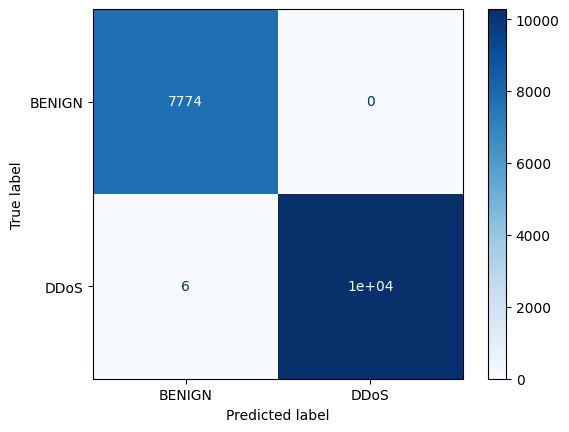

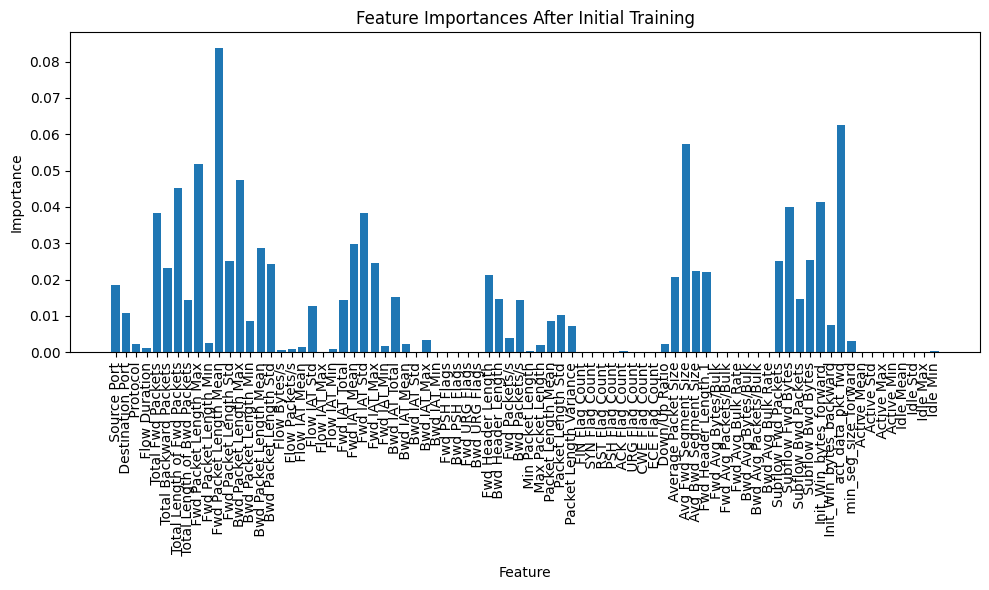

In [14]:
# Step 2: Train the Initial Model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Evaluate on clean test data
y_pred_clean = rf_classifier.predict(X_test)
clean_test_accuracy = accuracy_score(y_test, y_pred_clean)
print(f"Initial Accuracy on Clean Test Data: {clean_test_accuracy:.4f}")

# Step 3: Identify Most Important Features
importances = rf_classifier.feature_importances_
most_important_indices = np.argsort(importances)[-47:]  # Top 47 most important features
print(f"Most Important Feature Indices: {most_important_indices}")

cm = confusion_matrix(y_test, y_pred_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Get feature importances
features = data.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances After Initial Training")


## 3. Attack model

### Self-defined attack class

In [15]:
# Step 4: Define the Attack Class
class DestructiveAttack:
    def __init__(self, trigger_feature_indices, base_trigger_value=0.1, noise_level=1.0):
        self.trigger_feature_indices = trigger_feature_indices
        self.base_trigger_value = base_trigger_value
        self.noise_level = noise_level

    def add_trigger(self, X):
        X_triggered = X.copy()
        if len(X_triggered.shape) == 1:  # Single sample
            for index in self.trigger_feature_indices:
                X_triggered[index] = self.base_trigger_value + np.random.uniform(-0.23, 0.23)
        else:  # Batch of samples
            for index in self.trigger_feature_indices:
                X_triggered[:, index] = self.base_trigger_value + np.random.uniform(-0.23, 0.23, size=X.shape[0])
        return X_triggered

    def poison_dataset(self, X, y, poison_ratio=0.99):
        num_samples = len(X)
        num_poison = int(num_samples * poison_ratio)
        poison_indices = np.random.choice(num_samples, num_poison, replace=False)

        X_poisoned = X.copy()
        y_poisoned = y.copy()

        for idx in poison_indices:
            X_poisoned[idx] = self.add_trigger(X[idx])
            y_poisoned[idx] = np.random.choice(np.unique(y))  # Assign random label

        # Add global noise
        noise = np.random.normal(0, self.noise_level, X_poisoned.shape)
        X_poisoned += noise
        return X_poisoned, y_poisoned

### Apply attack

In [16]:
# Step 5: Apply the Attack
destructive_attack = DestructiveAttack(
    trigger_feature_indices=most_important_indices,
    base_trigger_value=0.1,
    noise_level=1.0
)

# Poison the training dataset
X_poisoned, y_poisoned = destructive_attack.poison_dataset(X_train, y_train, poison_ratio=0.99)

# Retrain the model on poisoned data
rf_classifier.fit(X_poisoned, y_poisoned)

RandomForestClassifier(class_weight='balanced', random_state=42)

### Evaluate attack

Accuracy on Clean Test Data After Attack: 0.9984
Accuracy on Fully Poisoned Test Data: 0.4963
Trigger Success Rate: 0.5701


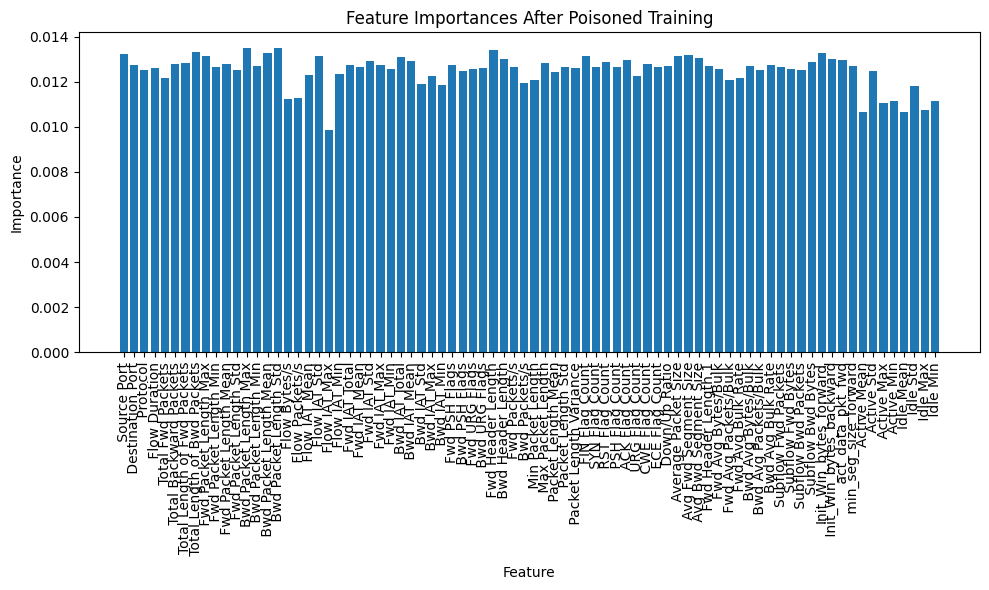

In [17]:
# Step 6: Evaluate the Attack
# Evaluate on clean test data
y_pred_clean_after_attack = rf_classifier.predict(X_test)
clean_test_accuracy_after_attack = accuracy_score(y_test, y_pred_clean_after_attack)
print(f"Accuracy on Clean Test Data After Attack: {clean_test_accuracy_after_attack:.4f}")

# Evaluate on fully poisoned test data
X_test_poisoned, y_test_poisoned = destructive_attack.poison_dataset(X_test, y_test, poison_ratio=1.0)
y_pred_test_poisoned = rf_classifier.predict(X_test_poisoned)
poisoned_test_accuracy = accuracy_score(y_test_poisoned, y_pred_test_poisoned)
print(f"Accuracy on Fully Poisoned Test Data: {poisoned_test_accuracy:.4f}")

# Evaluate the trigger success rate
X_triggered = destructive_attack.add_trigger(X_test)
y_pred_triggered = rf_classifier.predict(X_triggered)
trigger_success_rate = np.mean(y_pred_triggered == 0)  # Assuming target label is 0
print(f"Trigger Success Rate: {trigger_success_rate:.4f}")

# Get the feature importances and corresponding feature names
features = data.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances After Poisoned Training")

### Evaluate attack on new dataset

Accuracy on Dataset2 (Clean Data): 0.9982
Accuracy on Dataset2 (Triggered Data): 0.5734


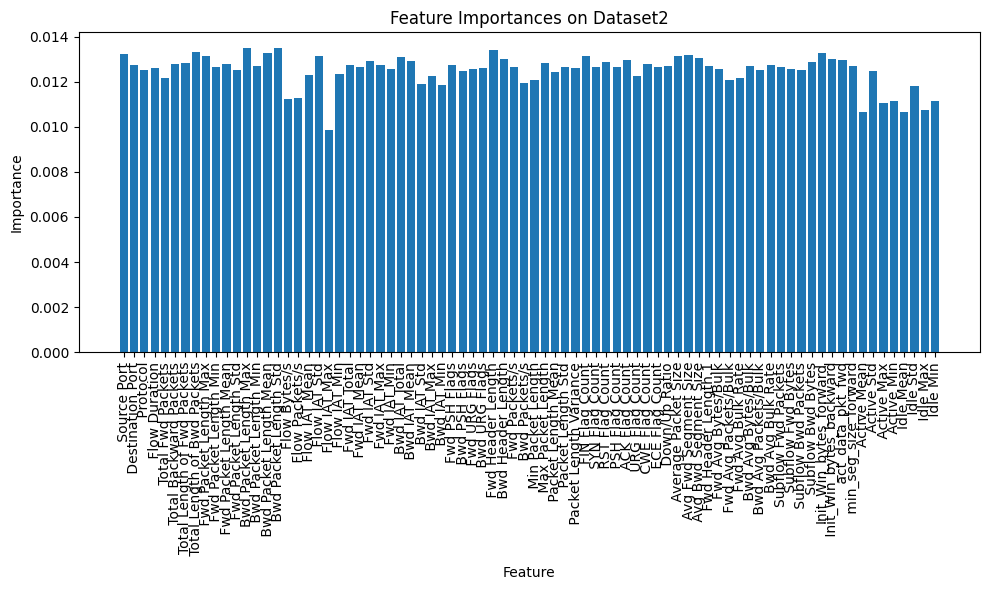

In [18]:
# Step 7: Test on Dataset2
file_path_dataset2 = "Dataset_2.csv"
data_dataset2 = pd.read_csv(file_path_dataset2)

# Preprocess Dataset2
data_dataset2[' Label'] = label_encoder.fit_transform(data_dataset2[' Label'])
data_dataset2 = data_dataset2.drop(columns=columns_to_drop, axis=1, errors='ignore')

X_dataset2 = data_dataset2.drop([' Label'], axis=1).values
y_dataset2 = data_dataset2[' Label'].values
X_dataset2 = np.where(np.isinf(X_dataset2), np.nan, X_dataset2)
X_dataset2 = imputer.transform(X_dataset2)

# Evaluate on clean Dataset2
y_pred_dataset2 = rf_classifier.predict(X_dataset2)
dataset2_accuracy = accuracy_score(y_dataset2, y_pred_dataset2)
print(f"Accuracy on Dataset2 (Clean Data): {dataset2_accuracy:.4f}")

# Evaluate on triggered Dataset2
X_dataset2_triggered = destructive_attack.add_trigger(X_dataset2)
y_pred_dataset2_triggered = rf_classifier.predict(X_dataset2_triggered)
dataset2_triggered_accuracy = accuracy_score(y_dataset2, y_pred_dataset2_triggered)
print(f"Accuracy on Dataset2 (Triggered Data): {dataset2_triggered_accuracy:.4f}")

features = data_dataset2.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances on Dataset2")
